# Solving linear systems of equations using HHL and its Qiskit implementation

In this tutorial, we introduce the HHL algorithm, derive the circuit, and implement it using Qiskit. We show how to run the HHL on a simulator and on a five qubit device.

## Contents
1. [Introduction](#introduction)
2. [The HHL algorithm](#hhlalg)
    1. [Some mathematical background](#mathbackground)
    2. [Description of the HHL](#hhldescription)
    3. [Quantum Phase Estimation (QPE) within HHL](#qpe)
    4. [Non-exact QPE](#qpe2)
3. [Example 1: 4-qubit HHL](#example1)
4. [Qiskit Implementation](#implementation)
    1. [Running HHL on a simulator: general method](#implementationsim)
    2. [Running HHL on a real quantum device: optimised example](#implementationdev)
5. [Problems](#problems)
6. [References](#references)

## 1. Introduction <a id='introduction'></a>

We see systems of linear equations in many real-life applications across a wide range of areas. Examples include the solution of Partial Differential Equations, the calibration of financial models, fluid simulation or numerical field calculation. The problem can be defined as, given a matrix $A\in\mathbb{C}^{N\times N}$ and a vector $\vec{b}\in\mathbb{C}^{N}$, find $\vec{x}\in\mathbb{C}^{N}$ satisfying $A\vec{x}=\vec{b}$

For example, take $N=2$, 

$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix},\quad \vec{x}=\begin{pmatrix} x_{1}\\ x_{2}\end{pmatrix}\quad \text{and} \quad \vec{b}=\begin{pmatrix}1 \\ 0\end{pmatrix}$$

Then the problem can also be written as find $x_{1}, x_{2}\in\mathbb{C}$ such that
$$\begin{cases}x_{1} - \frac{x_{2}}{3} = 1 \\ -\frac{x_{1}}{3} + x_{2} = 0\end{cases} $$

A system of linear equations is called $s$-sparse if $A$ has at most $s$ non-zero entries per row or column. Solving an $s$-sparse system of size $N$ with a classical computer requires $\mathcal{ O }(Ns\kappa\log(1/\epsilon))$ running time using the conjugate gradient method <sup>[1](#conjgrad)</sup>. Here $\kappa$ denotes the condition number of the system and $\epsilon$ the accuracy of the approximation.

The HHL algorithm estimates a function of the solution with running time complexity of $\mathcal{ O }(\log(N)s^{2}\kappa^{2}/\epsilon)$<sup>[2](#hhl)</sup>. The matrix $A$ must be Hermitian, and we assume we have efficient oracles for loading the data, Hamiltonian simulation, and computing a function of the solution. This is an exponential speed up in the size of the system, with the catch that HHL can only approximate functions of the solution vector, while the classical algorithm returns the full solution.

## 2. The HHL algorithm<a id='hhlalg'></a>

### A. Some mathematical background<a id='mathbackground'></a>
The first step towards solving a system of linear equations with a quantum computer is to encode the problem in the quantum language. By rescaling the system, we can assume $\vec{b}$ and $\vec{x}$ to be normalised and map them to the respective quantum states $|b\rangle$ and $|x\rangle$. Usually the mapping used is such that $i^{th}$ component of $\vec{b}$ (resp. $\vec{x}$) corresponds to the amplitude of the $i^{th}$ basis state of the quantum state $|b\rangle$ (resp. $|x\rangle$). From now on, we will focus on the rescaled problem

$$ A|x\rangle=|b\rangle$$

Since $A$ is Hermitian, it has a spectral decomposition
$$
A=\sum_{j=0}^{N-1}\lambda_{j}|u_{j}\rangle\langle u_{j}|,\quad \lambda_{j}\in\mathbb{ R }
$$
where $|u_{j}\rangle$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,
$$
A^{-1}=\sum_{j=0}^{N-1}\lambda_{j}^{-1}|u_{j}\rangle\langle u_{j}|
$$
and the right hand side of the system can be written in the eigenbasis of $A$ as
$$
|b\rangle=\sum_{j=0}^{N-1}b_{j}|u_{j}\rangle,\quad b_{j}\in\mathbb{ C }
$$
It is useful to keep in mind that the goal of the HHL is to exit the algorithm with the readout register in the state
$$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1}\lambda_{j}^{-1}b_{j}|u_{j}\rangle
$$
Note that here we already have an implicit normalisation constant since we are talking about a quantum state.

### B. Description of the HHL algorithm <a id='hhldescription'></a>

The algorithm uses three quantum registers, all set to $|0\rangle $ at the beginning of the algorithm. One register, which we will denote with the subindex $n_{l}$, is used to store a binary representation of the eigenvalues of $A$. A second register, denoted by $n_{b}$, contains the vector solution, and from now on $N=2^{n_{b}}$. There is an extra register for auxiliary qubits, used for intermediate steps in the computation. We can ignore any auxiliary in the following description as they are $|0\rangle $ at the beginning of each computation, and are restored back to $|0\rangle $ at the end of each individual operation.

The following is an outline of the HHL algorithm with a high-level drawing of the corresponding circuit. For simplicity all computations are assumed to be exact in the ensuing description, and a more detailed explanation of the non-exact case is given in Section [2.D.](#qpe2).

<img src="images/hhlcircuit.png" width = "75%" height = "75%">

<!-- vale QiskitTextbook.Spelling = NO -->

1.  Load the data $|b\rangle\in\mathbb{ C }^{N}$. That is, perform the transformation
    $$ |0\rangle _{n_{b}} \mapsto |b\rangle _{n_{b}} $$
2. Apply Quantum Phase Estimation (QPE) with
    $$ U = e ^ { i A t } := \sum _{j=0}^{N-1}e ^ { i \lambda _ { j } t } |u_{j}\rangle\langle u_{j}| $$
	The quantum state of the register expressed in the eigenbasis of $A$ is now
    $$ \sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}} $$
    where $ |\lambda _ {j }\rangle_{n_{l}}$ is the $n_{l}$-bit binary representation of $\lambda _ {j }$.
    
3. Add an auxiliary qubit and apply a rotation conditioned on $|\lambda_{ j }\rangle$,
    $$ \sum_{j=0}^{N-1} b _ { j } |\lambda _ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac { C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right) $$
	where $C$ is a normalisation constant, and, as expressed in the current form above, should be less than the smallest eigenvalue $\lambda_{min}$ in magnitude, i.e., $|C| < \lambda_{min}$.
    
4. Apply the inverse of QPE. Ignoring possible errors from QPE, this results in
    $$ \sum_{j=0}^{N-1} b _ { j } |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac {C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right) $$
    
5. Measure the auxiliary qubit in the computational basis. If the outcome is $1$, the register is in the post-measurement state
    $$ \left( \sqrt { \frac { 1 } { \sum_{j=0}^{N-1} \left| b _ { j } \right| ^ { 2 } / \left| \lambda _ { j } \right| ^ { 2 } } } \right) \sum _{j=0}^{N-1} \frac{b _ { j }}{\lambda _ { j }} |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} $$
	which up to a normalisation factor corresponds to the solution.

6. Apply an observable $M$ to calculate $F(x):=\langle x|M|x\rangle$.

### C. Quantum Phase Estimation (QPE) within HHL <a id='qpe'></a>

Quantum Phase Estimation is described in more detail in Chapter 3. However, since this quantum procedure is at the core of the HHL algorithm, we recall here the definition. Roughly speaking, it is a quantum algorithm which, given a unitary $U$ with eigenvector $|\psi\rangle_{m}$ and eigenvalue $e^{2\pi i\theta}$, finds $\theta$. We can formally define this as follows.

**Definition:** Let $U\in\mathbb{ C }^{2^{m}\times 2^{m}}$ be unitary and let $|\psi\rangle_{m}\in\mathbb{ C }^{2^{m}}$ be one of its eigenvectors with respective eigenvalue $e^{2\pi i\theta}$. The **Quantum Phase Estimation** algorithm, abbreviated **QPE**, takes as inputs the unitary gate for $U$ and the state $|0\rangle_{n}|\psi\rangle_{m}$ and returns the state $|\tilde{\theta}\rangle_{n}|\psi\rangle_{m}$. Here $\tilde{\theta}$ denotes a binary approximation to $2^{n}\theta$ and the $n$ subscript denotes it has been truncated to $n$ digits.	
$$
\operatorname { QPE } ( U , |0\rangle_{n}|\psi\rangle_{m} ) = |\tilde{\theta}\rangle_{n}|\psi\rangle_{m}
$$

For the HHL we will use QPE with $U = e ^ { i A t }$, where $A$ is the matrix associated to the system we want to solve. In this case, 
$$
e ^ { i A t } = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}|u_{j}\rangle\langle u_{j}|
$$
Then, for the eigenvector $|u_{j}\rangle_{n_{b}}$, which has eigenvalue $e ^ { i \lambda _ { j } t }$, QPE will output $|\tilde{\lambda }_ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}$. Where $\tilde{\lambda }_ { j }$ represents an $n_{l}$-bit binary approximation to $2^{n_l}\frac{\lambda_ { j }t}{2\pi}$. Therefore, if each $\lambda_{j}$ can be exactly represented with $n_{l}$ bits,
$$
\operatorname { QPE } ( e ^ { i A t } , \sum_{j=0}^{N-1}b_{j}|0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} ) = \sum_{j=0}^{N-1}b_{j}|\lambda_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
$$

### D. Non-exact QPE <a id='qpe2'></a>

In reality, the quantum state of the register after applying QPE to the initial state is

$$ \sum _ { j=0 }^{N-1} b _ { j } \left( \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } |l\rangle_{n_{l}} \right)|u_{j}\rangle_{n_{b}} $$
where

$$ \alpha _ { l | j } = \frac { 1 } { 2 ^ { n_{l} } } \sum _ { k = 0 } ^ { 2^{n_{l}}- 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l } { 2 ^ { n_{l} } } \right) } \right) ^ { k } $$

Denote by $\tilde{\lambda_{j}}$ the best $n_{l}$-bit approximation to $\lambda_{j}$, $1\leq j\leq N$. Then we can relabel the $n_{l}$-register so that $\alpha _ { l | j }$ denotes the amplitude of $|l + \tilde { \lambda } _ { j } \rangle_{n_{l}}$. So now,

$$\alpha _ { l | j } : = \frac { 1 } { 2 ^ { n_{l}} } \sum _ { k = 0 } ^ { 2 ^ { n_{l} } - 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } } \right) } \right) ^ { k }$$

If each $\frac { \lambda _ { j } t } { 2 \pi }$ can be represented exactly with $n_{l}$ binary bits, then $\frac { \lambda _ { j } t } { 2 \pi }=\frac { \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }, \forall j$. Therefore in this case $\forall j$, $1\leq j \leq N$, it holds that $\alpha _ { 0 | j } = 1$ and $\alpha _ { l | j } = 0 \quad \forall l \neq 0$. Only in this case we can write that the state of the register after QPE is 

$$ \sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}$$

Otherwise, $|\alpha _ { l | j }|$ is large if and only if $\frac { \lambda _ { j } t } { 2 \pi } \approx \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }$ and the state of the register is

$$ \sum _ { j=0 }^{N-1}  \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } b _ { j }|l\rangle_{n_{l}} |u_{j}\rangle_{n_{b}} $$

## 3. Example: 4-qubit HHL<a id='example1'></a>

Let's take the small example from the introduction to illustrate the algorithm. That is,
$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix}\quad \text{and} \quad |b\rangle=\begin{pmatrix}1 \\ 0\end{pmatrix}$$

We will use $n_{b}=1$ qubit to represent $|b\rangle$, and later the solution $|x\rangle$, $n_{l}=2$ qubits to store the binary representation of the eigenvalues and $1$ auxiliary qubit to store whether the conditioned rotation, hence the algorithm, was successful.

For the purpose of illustrating the algorithm, we will cheat a bit and calculate the eigenvalues of $A$ to be able to choose $t$ to obtain an exact binary representation of the rescaled eigenvalues in the $n_{l}$-register. However, keep in mind that for the HHL algorithm implementation one does not need previous knowledge of the eigenvalues. Having said that, a short calculation will give
$$\lambda_{1} = 2/3\quad\text{and}\quad\lambda_{2}=4/3$$

Recall from the previous section that the QPE will output an $n_{l}$-bit ($2$-bit in this case) binary approximation to $\frac{\lambda_ { j }t}{2\pi}$. Therefore, if we set 
$$t=2\pi\cdot \frac{3}{8}$$
the QPE will give a $2$-bit binary approximation to
$$\frac{\lambda_ { 1 }t}{2\pi} = 1/4\quad\text{and}\quad\frac{\lambda_ { 2 }t}{2\pi}=1/2$$
which is, respectively,
$$|01\rangle_{n_{l}}\quad\text{and}\quad|10\rangle_{n_{l}}$$

The eigenvectors are, respectively,
$$|u_{1}\rangle=\frac{1}{\sqrt{2}}\begin{pmatrix}1 \\ -1\end{pmatrix}\quad\text{and}\quad|u_{2}\rangle=\frac{1}{\sqrt{2}}\begin{pmatrix}1 \\ 1\end{pmatrix}$$

Again, keep in mind that one does not need to compute the eigenvectors for the HHL implementation. In fact, a general Hermitian matrix $A$ of dimension $N$ can have up to $N$ different eigenvalues, therefore calculating them would take $\mathcal{O}(N)$ time and the quantum advantage would be lost.

We can then write $|b\rangle$ in the eigenbasis of $A$ as
$$|b\rangle _{n_{b}}=\sum_{j=1}^{2}\frac{1}{\sqrt{2}}|u_{j}\rangle _{n_{b}}$$

Now we are ready to go through the different steps of the HHL algorithm. 

1. State preparation in this example is trivial since $|b\rangle=|0\rangle$.
2. Applying QPE will yield
$$
\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle
$$
3. Conditioned rotation with $C=1/8$ that is less than the smallest (rescaled) eigenvalue of $\frac {1} {4}$. Note, the constant $C$ here needs to be chosen such that it is less than the smallest (rescaled) eigenvalue of $\frac {1} {4}$ but as large as possible so that when the auxiliary qubit is measured, the probability of it being in the state $|1>$ is large.
$$\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2}  } {(1/4)^{2} } } |0\rangle + \frac { 1/8 } { 1/4 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2}  } {(1/2)^{2} } } |0\rangle + \frac { 1/8 } { 1/2 } |1\rangle \right)
$$
$$
=\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 1  } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 1  } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right)
$$
4. After applying the inverted QPE the quantum computer is in the state
$$
\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 1  } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 1  } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right)
$$
5. On outcome $1$ when measuring the auxiliary qubit, the state is 
$$
\frac{\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\frac { 1 } { 2 } |1\rangle + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\frac { 1 } { 4 } |1\rangle}{\sqrt{5/32}}
$$
A quick calculation shows that
$$
\frac{\frac{1}{2\sqrt{2}}|u_{1}\rangle+ \frac{1}{4\sqrt{2}}|u_{2}\rangle}{\sqrt{5/32}} = \frac{|x\rangle}{||x||}
$$
6. Without using extra gates, we can compute the norm of $|x\rangle$: it is the probability of measuring $1$ in the auxiliary qubit from the previous step.
$$
P(|1\rangle) = \left(\frac{1}{2\sqrt{2}}\right)^{2} + \left(\frac{1}{4\sqrt{2}}\right)^{2} = \frac{5}{32} = ||x||^{2}
$$

## 4. Qiskit Implementation<a id='implementation'></a>

Now that we have analytically solved the problem from the example we are going to use it to illustrate how to run the HHL on a quantum simulator and on the real hardware. The following uses `quantum_linear_solvers`, a Qiskit-based package. The most stratightforward way to install it  install it is through an old version of Qiskit using Python environments (see our README.md file). Alternatively, you can do a custom install downloading the code of this [repository](https://github.com/anedumla/quantum_linear_solvers) and installed as described in the corresponding `Readme` file. For the quantum simulator, `quantum_linear_solvers` already provides an implementation of the HHL algorithm requiring only the matrix $A$ and $|b\rangle$ as inputs in the simplest example. Although we can give the algorithm a general Hermitian matrix and an arbitrary initial state as NumPy arrays, in these cases the quantum algorithm will not achieve an exponential speedup. This is because the default implementation is exact and therefore exponential in the number of qubits. There is no algorithm polynomial resources in the number of qubits that can prepare an exact arbitrary quantum state, or that can perform the exact operation $e^{iAt}$ for some general Hermitian matrix $A$. If we know an efficient implementation for a particular problem, the matrix and/or the vector can be given as `QuantumCircuit` objects. Alternatively, there's already an efficient implementation for tridiagonal Toeplitz matrices and in the future there might be more.

## A. Running HHL on a simulator: general method<a id='implementationsim'></a>

To run the code on this page, we will use the linear solvers package in QisKit 0.40.0. The interface for all algorithms to solve the linear system problem is `LinearSolver`. The problem to be solved is only specified when the `solve()` method is called:
```python
LinearSolver(...).solve(matrix, vector)
```

The simplest implementation takes the matrix and the vector as NumPy arrays. Below we also create a `NumPyLinearSolver` (the classical algorithm) to validate our solutions.

### Classical Numpy solver

For the classical solver we need to rescale the right hand side (i.e. `vector / np.linalg.norm(vector)`) to take into account the renormalisation that occurs once `vector` is encoded in a quantum state within HHL.

In [2]:
import numpy as np
# pylint: disable=line-too-long
from qiskit.algorithms import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL

#Defining example matrix A and vector b
matrix = np.array([[1, -1/3], [-1/3, 1]])
vector = np.array([1, 0])

#C

def linalg_solve(matrix, vector):
    classical_solution=NumPyLinearSolver().solve(matrix,vector/np.linalg.norm(vector))
    return classical_solution

classical_solution = linalg_solve(matrix,vector/np.linalg.norm(vector))

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/3156863825.py:13: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_solution=NumPyLinearSolver().solve(matrix,vector/np.linalg.norm(vector))


### Exact quantum solution via HHL

To solve the system exactly with a quantum algorithm, we call the HHL library with default opetions on a given matrix vector without any optimizations. This will implement an exact (albeit highly inefficient) version of the quantum phase estimatio algorithm.

In [3]:
#Testing the HHL algorithm to solve the system of equations Ax=b. The code below computes a naive_hhl_solution x

naive_hhl_solution = HHL().solve(matrix, vector)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/1109749407.py:3: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  naive_hhl_solution = HHL().solve(matrix, vector)


### Efficient approximate Quantum Phase Estimation for Trigiadonal matrices

The `linear_solvers` package contains a folder called `matrices` intended to be a placeholder for efficient implementations of particular types of matrices. At the time of writing the only truly efficient implementation it contains (i.e. complexity scaling polynomially in the number of qubits) is the `TridiagonalToeplitz` class. Tridiagonal Toeplitz symmetric real matrices are of the following form 

$$A = \begin{pmatrix}a & b & 0 & 0\\b & a & b & 0 \\ 0 & b & a & b \\ 0 & 0 & b & a \end{pmatrix}, a,b\in\mathbb{R}$$

(note that in this setting we do not consider non symmetric matrices since the HHL algorithm assumes that the input matrix is Hermitian).

Since the matrix $A$ from our example is of this form we can create an instance of `TridiagonalToeplitz(num_qubits, a, b)` and compare the results to solving the system with an array as input.

In [4]:
## Assignment HHL
#When num_state_qubits=1 can be simulate in this machine
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz

# FUNCTION USAGE IS DOCUMENTED HERE https://docs.quantum.ibm.com/api/qiskit/0.40/qiskit.algorithms.linear_solvers.TridiagonalToeplitz
# class TridiagonalToeplitz(num_state_qubits, main_diag, off_diag, tolerance=0.01,
# evolution_time=1.0, trotter_steps=1, name='tridi')
# Pick num_state_qubits=n to create a 2^n x 2^n matrix


tridi_matrix = TridiagonalToeplitz(1, 1, -1 / 3)
tridi_solution = HHL().solve(tridi_matrix, vector)

print('tridi matrix: ',tridi_matrix)
print('tridi solution: ',tridi_solution)


tridi matrix:         
state: 
       
tridi solution:  {   'circuit_results': None,
    'euclidean_norm': 1.1858541225631367,
    'observable': None,
    'state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x133c79450>}


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/15451246.py:9: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  tridi_matrix = TridiagonalToeplitz(1, 1, -1 / 3)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/15451246.py:10: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  tridi_solution = HHL().solve(tridi_matrix, vector)


In [15]:
## Assignment HHL
# When num_state_qubits=2 can be simulate in this machine
# This is the system chosen to be solved 
from qiskit.algorithms.linear_solvers.observables import AbsoluteAverage, MatrixFunctional
from qiskit import QuantumCircuit

qc = QuantumCircuit(6)
num_state_qubits_2=2
vector_2 = np.array([1, 0, 0, 0])
matrix_2 = np.array([
    [1, -1 / 3, 0, 0],
    [-1 / 3, 1, 0, 0],
    [0, 0, 1, -1 / 3],
    [0, 0, -1 / 3, 1]
    ])

tridi_matrix_2 = TridiagonalToeplitz(num_state_qubits_2, 1, -1 / 3)
tridi_solution_2 = HHL().solve(tridi_matrix_2, vector_2)

print('tridi matrix: ',tridi_matrix_2)
print('tridi solution: ',tridi_solution_2)

average_solution_2 = HHL().solve(tridi_matrix_2,
                               vector_2,
                               AbsoluteAverage())

observable_2 = MatrixFunctional(1, 1 / 2)

functional_solution_2 = HHL().solve(tridi_matrix_2, vector_2, observable_2)
classical_functional_2 = NumPyLinearSolver(
                          ).solve(matrix_2,
                                  vector_2 / np.linalg.norm(vector_2),
                                  observable_2)

print('a) norm_x: ',tridi_solution_2.euclidean_norm )
print('b) avg_x: ',average_solution_2.observable )
print('c) quantum functional (inner_product):', functional_solution_2.observable)
print('d) classical functional (using linalg):', classical_functional_2.observable)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/60997851.py:21: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  tridi_matrix_2 = TridiagonalToeplitz(num_state_qubits_2, 1, -1 / 3)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/60997851.py:22: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  tridi_solution_2 = HHL().solve(tridi_matrix_2, vector_2)


tridi matrix:           
state_0: 
         
state_1: 
         
  a3290: 
         
tridi solution:  {   'circuit_results': None,
    'euclidean_norm': 1.209457721870527,
    'observable': None,
    'state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x15cefc220>}


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/60997851.py:27: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  average_solution_2 = HHL().solve(tridi_matrix_2,
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/60997851.py:29: DeprecationWarning: The AbsoluteAverage class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  AbsoluteAverage())
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/60997851.py:31: DeprecationWarning: The MatrixFunctional class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  observable_2 = MatrixFunctional(1, 1 / 2)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/60997

a) norm_x:  1.209457721870527
b) avg_x:  0.45005591965119346
c) quantum functional (inner_product): 2.034701011478756
d) classical functional (using linalg): 1.828125


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/60997851.py:34: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_functional_2 = NumPyLinearSolver(


In [53]:
## Assignment HHL
#Case_a when a,b are randomly chosen real numbers in the interval [-1,1] and n=2

import time

def run_hhl_with_tridiagonal_matrix(n, main_diag_range=(-1, 1), off_diag_range=(-1, 1)):
    """Generate a tridiagonal matrix and solve Ax = b using the HHL algorithm."""
    
    # matrix using the TridiagonalToeplitz class
    main_diag = np.random.uniform(main_diag_range)
    off_diag = np.random.uniform(off_diag_range)

    # Create the tridiagonal matrix
    A = TridiagonalToeplitz(n, main_diag[0], off_diag[0])
    
    # Generate a random vector b
    b = np.array([1, 0, 0, 0])
    
    # Measure the time taken to solve the system
    start_time = time.time()
    
    # Solve the system using HHL
    result = HHL().solve(A, b)
    
    # End the timer
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Extract solution and compute the vector norm
    solution = result.state

    print('solution', solution)

    print('norm', result.euclidean_norm)
    
    print(f"Time taken to solve the system: {elapsed_time:.4f} seconds")
    
    return A, b, solution, elapsed_time

case_a = run_hhl_with_tridiagonal_matrix(2)

maindiag:  0.908852344295402  off_diag:  -0.970639542944568
matrix:           
state_0: 
         
state_1: 
         
  a8761: 
         


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/4272020773.py:23: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  A = TridiagonalToeplitz(n, main_diag[0], off_diag[0])
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/4272020773.py:40: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  result = HHL().solve(A, b)


solution          ┌────────────────┐┌──────┐        ┌─────────┐
q9849_0: ┤0               ├┤5     ├────────┤5        ├
         │  circuit-67627 ││      │        │         │
q9849_1: ┤1               ├┤6     ├────────┤6        ├
         └────────────────┘│      │┌──────┐│         │
q9850_0: ──────────────────┤0     ├┤4     ├┤0        ├
                           │      ││      ││         │
q9850_1: ──────────────────┤1     ├┤3     ├┤1        ├
                           │  QPE ││      ││  QPE_dg │
q9850_2: ──────────────────┤2     ├┤2     ├┤2        ├
                           │      ││      ││         │
q9850_3: ──────────────────┤3     ├┤1 1/x ├┤3        ├
                           │      ││      ││         │
q9850_4: ──────────────────┤4     ├┤0     ├┤4        ├
                           │      ││      ││         │
  a8762: ──────────────────┤7     ├┤      ├┤7        ├
                           └──────┘│      │└─────────┘
  q9851: ──────────────────────────┤5     ├───────────
 

In [54]:
## Assignment HHL
#Case_b when a,b are randomly chosen real numbers in the interval [-n,n] and n=2

def run_hhl_with_tridiagonal_matrix_n(n):
    """Generate a tridiagonal matrix and solve Ax = b using the HHL algorithm."""
    
    # matrix using the TridiagonalToeplitz class
    main_diag = np.random.uniform(-n,n)
    off_diag = np.random.uniform(-n,n) 

    # Create the tridiagonal matrix
    A = TridiagonalToeplitz(n, main_diag, off_diag)
    
    # Generate a random vector b
    b = np.array([1, 0, 0, 0])

    # Measure the time taken to solve the system
    start_time = time.time()
    
    # Solve the system using HHL
    result = HHL().solve(A, b)
    
    # End the timer
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Extract solution and compute the vector norm
    solution = result.state

    print('solution', solution)

    print('norm', result.euclidean_norm)
    
    print(f"Time taken to solve the system: {elapsed_time:.4f} seconds")
    
    return A, b, solution, elapsed_time

case_b = run_hhl_with_tridiagonal_matrix_n(2)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/219226033.py:14: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  A = TridiagonalToeplitz(n, main_diag, off_diag)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/219226033.py:31: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  result = HHL().solve(A, b)


matrix:           
state_0: 
         
state_1: 
         
  a8972: 
         
solution           ┌────────────────┐┌──────┐        ┌─────────┐
q10073_0: ┤0               ├┤4     ├────────┤4        ├
          │  circuit-68872 ││      │        │         │
q10073_1: ┤1               ├┤5     ├────────┤5        ├
          └────────────────┘│      │┌──────┐│         │
q10074_0: ──────────────────┤0     ├┤3     ├┤0        ├
                            │      ││      ││         │
q10074_1: ──────────────────┤1 QPE ├┤2     ├┤1 QPE_dg ├
                            │      ││      ││         │
q10074_2: ──────────────────┤2     ├┤1     ├┤2        ├
                            │      ││  1/x ││         │
q10074_3: ──────────────────┤3     ├┤0     ├┤3        ├
                            │      ││      ││         │
   a8973: ──────────────────┤6     ├┤      ├┤6        ├
                            └──────┘│      │└─────────┘
  q10075: ──────────────────────────┤4     ├───────────
                

In [67]:
## Assignment HHL
#Case_b when a,b are randomly chosen real numbers in the interval [-2**n,2**n] and n=2

def run_hhl_with_tridiagonal_matrix_2n(n):
    """Generate a tridiagonal matrix and solve Ax = b using the HHL algorithm."""
    
    # matrix using the TridiagonalToeplitz class
    main_diag = np.random.uniform(-2**n,2**n)
    off_diag = np.random.uniform(-2**n,2**n)

    # Create the tridiagonal matrix
    A = TridiagonalToeplitz(n, main_diag, off_diag)
    
    # Generate a random vector b
    b = np.array([1, 0, 0, 0])
    
    # Measure the time taken to solve the system
    start_time = time.time()
    
    # Solve the system using HHL
    result = HHL().solve(A, b)
    
    # End the timer
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Extract solution and compute the vector norm
    solution = result.state

    print('solution', solution)

    print('norm', result.euclidean_norm)
    
    print(f"Time taken to solve the system: {elapsed_time:.4f} seconds")
    
    return A, b, solution, elapsed_time

case_c = run_hhl_with_tridiagonal_matrix_2n(2)
print(case_c)

maindiag:  0.005825007291683448  off_diag:  -1.482302220150232
matrix:           
state_0: 
         
state_1: 
         
 a11043: 
         


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/1659779594.py:14: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  A = TridiagonalToeplitz(n, main_diag, off_diag)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/1659779594.py:31: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  result = HHL().solve(A, b)


solution           ┌────────────────┐┌──────┐        ┌─────────┐
q12309_0: ┤0               ├┤4     ├────────┤4        ├
          │  circuit-80806 ││      │        │         │
q12309_1: ┤1               ├┤5     ├────────┤5        ├
          └────────────────┘│      │┌──────┐│         │
q12310_0: ──────────────────┤0     ├┤3     ├┤0        ├
                            │      ││      ││         │
q12310_1: ──────────────────┤1 QPE ├┤2     ├┤1 QPE_dg ├
                            │      ││      ││         │
q12310_2: ──────────────────┤2     ├┤1     ├┤2        ├
                            │      ││  1/x ││         │
q12310_3: ──────────────────┤3     ├┤0     ├┤3        ├
                            │      ││      ││         │
  a11044: ──────────────────┤6     ├┤      ├┤6        ├
                            └──────┘│      │└─────────┘
  q12311: ──────────────────────────┤4     ├───────────
                                    └──────┘           
norm 0.9591525906006111
Time taken to s

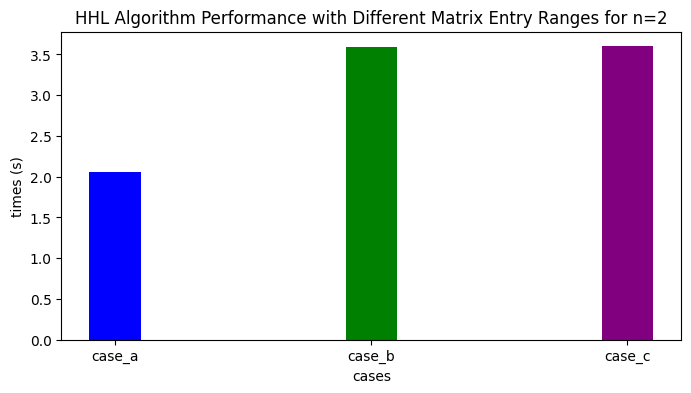

In [82]:
## Assignment HHL
# Plot of the cases and times
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
    
n_values = ['case_a', 'case_b', 'case_c']
times = [case_a[3], case_b[3], case_c[3]]
plt.bar(n_values, times, color=['blue', 'green', 'purple'], width=0.2)
    
plt.xlabel("cases")
plt.ylabel("times (s)")
plt.title("HHL Algorithm Performance with Different Matrix Entry Ranges for n=2")
# plt.legend()
# plt.grid(True)
plt.show()

In [54]:
## Assignment HHL
# When num_state_qubits=3 can be simulate in this machine
num_state_qubits_3=3
vector_3 = np.array([1, 0, 0, 0, 0, 0, 0 ,0])

tridi_matrix_3 = TridiagonalToeplitz(num_state_qubits_3, 1, -1 / 3)
tridi_solution_3 = HHL().solve(tridi_matrix_3, vector_3)


print('tridi matrix: ',tridi_matrix_3)
print('tridi solution: ',tridi_solution_3)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/2451086532.py:4: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  tridi_matrix_3 = TridiagonalToeplitz(num_state_qubits_3, 1, -1 / 3)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/2451086532.py:5: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  tridi_solution_3 = HHL().solve(tridi_matrix_3, vector_3)


tridi matrix:           
state_0: 
         
state_1: 
         
state_2: 
         
a1706_0: 
         
a1706_1: 
         
tridi solution:  {   'circuit_results': None,
    'euclidean_norm': 1.227424717239001,
    'observable': None,
    'state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1568e0370>}


In [55]:
## Assignment HHL
# When num_state_qubits=4 can be simulate in this machine
num_state_qubits_4=4

vector_4 = np.array([1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0])

tridi_matrix_4 = TridiagonalToeplitz(num_state_qubits_4, 1, -1 / 3)
tridi_solution_4 = HHL().solve(tridi_matrix_4, vector_4)

print('tridi matrix: ',tridi_matrix_4)
print('tridi solution: ',tridi_solution_4)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/2326443289.py:5: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  tridi_matrix_4 = TridiagonalToeplitz(num_state_qubits_4, 1, -1 / 3)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/2326443289.py:6: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  tridi_solution_4 = HHL().solve(tridi_matrix_4, vector_4)


tridi matrix:           
state_0: 
         
state_1: 
         
state_2: 
         
state_3: 
         
a1871_0: 
         
a1871_1: 
         
a1871_2: 
         
tridi solution:  {   'circuit_results': None,
    'euclidean_norm': 1.2059174605960543,
    'observable': None,
    'state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x177828d90>}


In [14]:
## Assignment HHL
# When num_state_qubits=5 can NOT be simulate in this machine, at the end details of the processor.
num_state_qubits_5=5

vector_5 = np.array([1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tridi_matrix_5 = TridiagonalToeplitz(num_state_qubits_5, 1, -1 / 3)
tridi_solution_5 = HHL().solve(tridi_matrix_5, vector_5)

print('tridi matrix: ',tridi_matrix_5)
print('tridi solution: ',tridi_solution_5)

# For num_state_qubits_5=5 is too large for this computer

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/3863912831.py:5: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  tridi_matrix_5 = TridiagonalToeplitz(num_state_qubits_5, 1, -1 / 3)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_8007/3863912831.py:6: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  tridi_solution_5 = HHL().solve(tridi_matrix_5, vector_5)


ValueError: 'to_matrix' will return an exponentially large vector, in this case '131072' elements. Set algorithm_globals.massive=True or the method argument massive=True if you want to proceed.

Recall that the HHL algorithm can find a solution exponentially faster in the size of the system than their classical counterparts (i.e. logarithmic complexity instead of polynomial). However the cost for this exponential speedup is that we do not obtain the full solution vector.
Instead, we obtain a quantum state representing the vector $x$ and learning all the components of this vector would take a linear time in its dimension, diminishing any speedup obtained by the quantum algorithm.

Therefore, we can only compute functions from $x$ (the so called observables) to learn information about the solution.
This is reflected in the `LinearSolverResult` object returned by `solve()`, which contains the following properties
- `state`: either the circuit that prepares the solution or the solution as a vector
- `euclidean_norm`: the euclidean norm if the algorithm knows how to calculate it 
- `observable`: the (list of) calculated observable(s)
- `circuit_results`: the observable results from the (list of) circuit(s)

Let's ignore `observable` and `circuit_results` for the time being and check the solutions we obtained before.

First, `classical_solution` was the result from a classical algorithm, so if we call `.state` it will return an array:

In [4]:
print('classical state:', classical_solution.state)

classical state: [1.125 0.375]


Our other two examples were quantum algorithms, hence we can only access to the quantum state. This is achieved by returning the quantum circuit that prepares the solution state:

In [5]:
# The code below depicts quantum states by giving explicit 
# quantum circuits that prepare such states. It uses the Qiskit HHL class

print('naive state:')
print(naive_hhl_solution.state)

print('tridiagonal state:')
print(tridi_solution.state)

naive state:
      ┌────────────┐┌──────┐        ┌─────────┐
  q4: ┤ circuit-94 ├┤3     ├────────┤3        ├
      └────────────┘│      │┌──────┐│         │
q5_0: ──────────────┤0     ├┤2     ├┤0        ├
                    │  QPE ││      ││  QPE_dg │
q5_1: ──────────────┤1     ├┤1     ├┤1        ├
                    │      ││  1/x ││         │
q5_2: ──────────────┤2     ├┤0     ├┤2        ├
                    └──────┘│      │└─────────┘
  q6: ──────────────────────┤3     ├───────────
                            └──────┘           
tridiagonal state:
       ┌─────────────┐┌──────┐        ┌─────────┐
  q26: ┤ circuit-307 ├┤3     ├────────┤3        ├
       └─────────────┘│      │┌──────┐│         │
q27_0: ───────────────┤0     ├┤2     ├┤0        ├
                      │  QPE ││      ││  QPE_dg │
q27_1: ───────────────┤1     ├┤1     ├┤1        ├
                      │      ││  1/x ││         │
q27_2: ───────────────┤2     ├┤0     ├┤2        ├
                      └──────┘│      │└─

Recall that the Euclidean norm for a vector $\mathbf{x}=(x_1,\dots,x_N)$ is defined as $||\mathbf{x}||=\sqrt{\sum_{i=1}^N x_i^2}$. Therefore, the probability of measuring $1$ in the auxiliary qubit from Step $5$ in Section B is the squared norm of $\mathbf{x}$. This means that the HHL algorithm can always calculate the euclidean norm of the solution and we can compare the accuracy of the results:

In [14]:
print('classical Euclidean norm:', classical_solution.euclidean_norm)
print('naive Euclidean norm:', naive_hhl_solution.euclidean_norm)
print('tridiagonal Euclidean norm:', tridi_solution.euclidean_norm)

classical Euclidean norm: 1.1858541225631423
naive Euclidean norm: 1.1858541225631383
tridiagonal Euclidean norm: 1.1858541225631367


Comparing the solution vectors component-wise is more tricky, reflecting again the idea that we cannot obtain the full solution vector from the quantum algorithm. However, for educational purposes we can check that indeed the different solution vectors obtained are a good approximation at the vector component level as well. 

To do so first we need to use `Statevector` from the `quantum_info` package and extract the right vector components, i.e. those corresponding to the ancillary qubit (bottom in the circuits) being $1$ and the work qubits (the two middle in the circuits) being $0$. Thus, we are interested in the states `10000` and `10001`, corresponding to the first and second components of the solution vector respectively.

In [15]:
from qiskit.quantum_info import Statevector

naive_sv = Statevector(naive_hhl_solution.state).data
tridi_sv = Statevector(tridi_solution.state).data

# Extract vector components; 10000(bin) == 16 & 10001(bin) == 17
naive_full_vector = np.array([naive_sv[16], naive_sv[17]])
tridi_full_vector = np.array([tridi_sv[16], tridi_sv[17]])

print('naive raw solution vector:', naive_full_vector)
print('tridi raw solution vector:', tridi_full_vector)

naive raw solution vector: [0.75+3.55149157e-16j 0.25+2.36995154e-16j]
tridi raw solution vector: [0.75-3.33656672e-17j 0.25+3.87715431e-16j]


At a first glance it might seem that this is wrong because the components are complex numbers instead of reals. However note that the imaginary part is very small, most likely due to computer accuracy, and can be disregarded in this case (we'll use the array's `.real` attribute to get the real part).

Next, we will divide the vectors by their respective norms to suppress any constants coming from the different parts of the circuits. The full solution vector can then be recovered by multiplying these normalised vectors by the respective Euclidean norms calculated above:

In [16]:
def get_solution_vector(solution):
    """Extracts and normalizes simulated state vector
    from LinearSolverResult."""
    solution_vector = Statevector(solution.state).data[16:18].real
    norm = solution.euclidean_norm
    return norm * solution_vector / np.linalg.norm(solution_vector)

print('full naive solution vector:', get_solution_vector(naive_hhl_solution))
print('full tridi solution vector:', get_solution_vector(tridi_solution))
print('classical state:', classical_solution.state)

full naive solution vector: [1.125 0.375]
full tridi solution vector: [1.125 0.375]
classical state: [1.125 0.375]


It should not come as a surprise that `naive_hhl_solution` is exact because all the default methods used are exact. However, `tridi_solution` is exact only in the $2\times 2$ system size case. For larger matrices it will be an approximation, as shown in the slightly larger example below.

In [17]:
from scipy.sparse import diags

NUM_QUBITS = 2
MATRIX_SIZE = 2 ** NUM_QUBITS
# entries of the tridiagonal Toeplitz symmetric matrix
# pylint: disable=invalid-name
a = 1
b = -1/3


matrix = diags([b, a, b],
               [-1, 0, 1],
               shape=(MATRIX_SIZE, MATRIX_SIZE)).toarray()

vector = np.array([1] + [0]*(MATRIX_SIZE - 1))

# run the algorithms

classical_solution = NumPyLinearSolver(
                        ).solve(matrix, vector / np.linalg.norm(vector))

naive_hhl_solution = HHL().solve(matrix, vector)

tridi_matrix = TridiagonalToeplitz(NUM_QUBITS, a, b)
tridi_solution = HHL().solve(tridi_matrix, vector)

print('classical euclidean norm:', classical_solution.euclidean_norm)
print('naive euclidean norm:', naive_hhl_solution.euclidean_norm)
print('tridiagonal euclidean norm:', tridi_solution.euclidean_norm)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/3455507905.py:19: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_solution = NumPyLinearSolver(
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/3455507905.py:22: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  naive_hhl_solution = HHL().solve(matrix, vector)
/Users/rocio/UIMPIntroToQuantumAI/.conda/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/rocio/UIMPIntroToQuantumAI/.conda/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid 

classical euclidean norm: 1.237833351044751
naive euclidean norm: 1.2099806231118972
tridiagonal euclidean norm: 1.209457721870527


We can also compare the difference in resources from the exact method and the efficient implementation. The $2\times 2$ system size is again special in that the exact algorithm requires less resources, but as we increase the system size, we can see that indeed the exact method scales exponentially in the number of qubits while `TridiagonalToeplitz` is polynomial.

In [18]:
from qiskit import transpile
from qiskit.utils import algorithm_globals

#Global Variable algorithm_globals.massive
# Default value False 
# Set algorithm_globals.massive=True for large qubit numbers (be careful, it can generate exponentially large vectors)
algorithm_globals.massive=True 

# Default value is 4, change for doing estimations with larger qubit numbers.
# Be careful with large system sizes:

#   a) The naive_hhl is more accurate yet requires very large circuit sizes.
#   For large qubit numbers, you may only be able to use the tridiagonal method.

#   b) For large qubit numbers, exonentially large matrices will be generated. 
#   By default, Qiskit limits large qubit numbers to be used to prevent memory issues.
#   To change this, you must set the global vairable (see above) algorithm_globals.massive=True

MAX_QUBITS = 4
a = 1
b = -1/3

i = 1
# calculate the circuit depths for different number of qubits to compare the use
# of resources (WARNING: This will take a while to execute)
naive_depths = []
tridi_depths = []

for n_qubits in range(1, MAX_QUBITS+1):
    matrix = diags([b, a, b],
                   [-1, 0, 1],
                   shape=(2**n_qubits, 2**n_qubits)).toarray()
    vector = np.array([1] + [0]*(2**n_qubits -1))

    naive_hhl_solution = HHL().solve(matrix, vector)
    tridi_matrix = TridiagonalToeplitz(n_qubits, a, b)
    tridi_solution = HHL().solve(tridi_matrix, vector)

    naive_qc = transpile(naive_hhl_solution.state,
                         basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
    tridi_qc = transpile(tridi_solution.state,
                         basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
    naive_depths.append(naive_qc.depth())
    tridi_depths.append(tridi_qc.depth())
    i +=1

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/817375534.py:35: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  naive_hhl_solution = HHL().solve(matrix, vector)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/817375534.py:36: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  tridi_matrix = TridiagonalToeplitz(n_qubits, a, b)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/817375534.py:37: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-appl

In [19]:
sizes = [f"{2**n_qubits}×{2**n_qubits}"
         for n_qubits in range(1, MAX_QUBITS+1)]
columns = ['size of the system',
   #        'quantum_solution depth',
           'tridi_solution depth']
data = np.array([sizes, #naive_depths, 
                 tridi_depths])
ROW_FORMAT ="{:>23}" * (len(columns) + 2)
for team, row in zip(columns, data):
    print(ROW_FORMAT.format(team, *row))

     size of the system                    2×2                    4×4                    8×8
   tridi_solution depth                    565                   5107                  14756


The reason the implementation still seems to need exponential resources is because the current conditioned rotation implementation (step 3 from Section 2.B) is exact (i.e. needs exponential resources in $n_l$). Instead we can calculate how many more resources the default implementation needs compared to Tridiagonal - since they only differ in how they implement $e^{iAt}$:

In [20]:
print('excess:',
      [naive_depths[i] - tridi_depths[i] for i in range(0, len(naive_depths))])

excess: [-231, -2529, 18416, 303041]


In the near future the plan is to integrate `qiskit.circuit.library.arithmetics.PiecewiseChebyshev` to obtain a polynomial implementation of the conditioned rotation as well.

### Estimation of observables

Now we can return to the topic of observables and find out what the `observable` and `circuit_results` properties contain.

The way to compute functions of the solution vector $\mathbf{x}$ is through giving the `.solve()` method a `LinearSystemObservable` as input. There are two types of available `LinearSystemObservable` which can be given as input:

#### Average of vector entries

For a vector $\mathbf{x}=(x_1,...,x_N)$, the $AbsoluteAverage$ observable computes $|\frac{1}{N}\sum_{i=1}^{N}x_i|$

In [21]:
from qiskit.algorithms.linear_solvers.observables import AbsoluteAverage, MatrixFunctional

NUM_QUBITS = 1
MATRIX_SIZE = 2 ** NUM_QUBITS
# entries of the tridiagonal Toeplitz symmetric matrix
a = 1
b = -1/3

matrix = diags([b, a, b],
               [-1, 0, 1],
               shape=(MATRIX_SIZE, MATRIX_SIZE)).toarray()
vector = np.array([1] + [0]*(MATRIX_SIZE - 1))
tridi_matrix = TridiagonalToeplitz(1, a, b)

average_solution = HHL().solve(tridi_matrix,
                               vector,
                               AbsoluteAverage())
classical_average = NumPyLinearSolver(
                        ).solve(matrix,
                                vector / np.linalg.norm(vector),
                                AbsoluteAverage())

print('quantum average:', average_solution.observable)
print('classical average:', classical_average.observable)
print('quantum circuit results:', average_solution.circuit_results)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/3200718449.py:13: DeprecationWarning: The TridiagonalToeplitz class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  tridi_matrix = TridiagonalToeplitz(1, a, b)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/3200718449.py:15: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  average_solution = HHL().solve(tridi_matrix,
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/3200718449.py:17: DeprecationWarning: The AbsoluteAverage class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  AbsoluteAverage())


quantum average: 0.7499999999999963
classical average: 0.75
quantum circuit results: (0.4999999999999952+0j)


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/3200718449.py:18: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_average = NumPyLinearSolver(
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/3200718449.py:21: DeprecationWarning: The AbsoluteAverage class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  AbsoluteAverage())


#### More general observables

The `MatrixFunctional` observable computes $\mathbf{x}^T B \mathbf{x}$ for a vector $\mathbf{x}$ and a tridiagonal symmetric Toeplitz matrix $B$. The class takes the main and off diagonal values of the matrix for its constructor method.

In [22]:
# Doc MatrixFunctional https://docs.quantum.ibm.com/api/qiskit/0.37/qiskit.algorithms.linear_solvers.MatrixFunctional
# class MatrixFunctional(main_diag, off_diag)

observable = MatrixFunctional(1, 1 / 2)

functional_solution = HHL().solve(tridi_matrix, vector, observable)
classical_functional = NumPyLinearSolver(
                          ).solve(matrix,
                                  vector / np.linalg.norm(vector),
                                  observable)

print('quantum functional:', functional_solution.observable)
print('classical functional:', classical_functional.observable)
print('quantum circuit results:', functional_solution.circuit_results)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/1700665276.py:4: DeprecationWarning: The MatrixFunctional class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  observable = MatrixFunctional(1, 1 / 2)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/1700665276.py:6: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  functional_solution = HHL().solve(tridi_matrix, vector, observable)


quantum functional: 1.8281249999999825
classical functional: 1.828125
quantum circuit results: [(0.6249999999999941+0j), (0.4999999999999952+0j), (0.1249999999999988+0j)]


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/1700665276.py:7: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_functional = NumPyLinearSolver(


Therefore, `observable` contains the final value of the function on $\mathbf{x}$, while `circuit_results` contains the raw values obtained from the circuit and used to process the result of `observable`.

This 'how to process the result' is better explained by looking at what arguments `.solve()` takes. The `solve()` method accepts up to five arguments: 
```python
def solve(self, matrix: Union[np.ndarray, QuantumCircuit],
          vector: Union[np.ndarray, QuantumCircuit],
          observable: Optional[Union[LinearSystemObservable, BaseOperator,
                                     List[BaseOperator]]] = None,
          post_rotation: Optional[Union[QuantumCircuit, List[QuantumCircuit]]] = None,
          post_processing: Optional[Callable[[Union[float, List[float]]],
                                             Union[float, List[float]]]] = None) \
        -> LinearSolverResult:
```
The first two are the matrix defining the linear system and the vector right hand side of the equation, which we have already covered. The remaining parameters concern the (list of) observable(s) to be computed out of the solution vector $x$, and can be specified in two different ways. One option is to give as the third and last parameter a (list of) `LinearSystemObservable`(s). Alternatively, we can give our own implementations of the `observable`, `post_rotation` and `post_processing`, where
- `observable` is the operator to compute the expected value of the observable and can be e.g. a `PauliSumOp`
- `post_rotation` is the circuit to be applied to the solution to extract information if additional gates are needed.
- `post_processing` is the function to compute the value of the observable from the calculated probabilities.

In other words, there will be as many `circuit_results` as `post_rotation` circuits, and `post_processing` is telling the algorithm how to use the values we see when we print `circuit_results` to obtain the value we see when we print `observable`.

Finally, the `HHL` class accepts the following parameters in its constructor method:
- error tolerance : the accuracy of the approximation of the solution, the default is `1e-2`
- expectation : how the expectation values are evaluated, the default is `PauliExpectation`
- quantum instance: the `QuantumInstance` or backend, the default is a `Statevector` simulation

In [23]:
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
hhl = HHL(1e-3, quantum_instance=backend)

accurate_solution = hhl.solve(matrix, vector)
classical_solution = NumPyLinearSolver(
                    ).solve(matrix,
                            vector / np.linalg.norm(vector))

print(accurate_solution.euclidean_norm)
print(classical_solution.euclidean_norm)

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/1762359573.py:4: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  hhl = HHL(1e-3, quantum_instance=backend)


1.1858541225631383
1.1858541225631423


/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_22345/1762359573.py:7: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_solution = NumPyLinearSolver(


## 8. References<a id='references'></a>

<!-- vale off -->

1. J. R. Shewchuk. An Introduction to the Conjugate Gradient Method Without the Agonizing Pain. Technical Report CMU-CS-94-125, School of Computer Science, Carnegie Mellon University, Pittsburgh, Pennsylvania, March 1994.<a id='conjgrad'></a> 
2. A. W. Harrow, A. Hassidim, and S. Lloyd, “Quantum algorithm for linear systems of equations,” Phys. Rev. Lett. 103.15 (2009), p. 150502.<a id='hhl'></a>
3. A. Dewes, F. R. Ong, V. Schmitt, R. Lauro, N. Boulant, P. Bertet, D. Vion, and D. Esteve, “Characterization of a two-transmon processor with individual single-shot qubit readout,” Phys. Rev. Lett. 108, 057002 (2012). <a id='readouterr'></a>
4. N. Stamatopoulos, D. J. Egger, Y. Sun, C. Zoufal, R. Iten, N. Shen, and S. Woerner, “Option Pricing using Quantum Computers,” arXiv:1905.02666 . <a id='richardson'></a>
5. A. Carrera Vazquez, A. Frisch, D. Steenken, H. S. Barowski, R. Hiptmair, and S. Woerner, “Enhancing Quantum Linear System Algorithm by Richardson Extrapolation,” ACM Trans. Quantum Comput. 3 (2022).<a id='tridi'></a>
6. R. Iten, O. Reardon-Smith, L. Mondada, E. Redmond, R. Singh Kohli, R. Colbeck, “Introduction to UniversalQCompiler,” arXiv:1904.01072 .<a id='qcompiler'></a>
7. https://quantum-computing.ibm.com/ .<a id='qexperience'></a>
8. D. Bucher, J. Mueggenburg, G. Kus, I. Haide, S. Deutschle, H. Barowski, D. Steenken, A. Frisch, "Qiskit Aqua: Solving linear systems of equations with the HHL algorithm" https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/aqua/linear_systems_of_equations.ipynb

In [24]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table

/Users/rocio/UIMPIntroToQuantumAI/.conda/lib/python3.10/site-packages/qiskit/tools/jupyter/__init__.py:132: RuntimeWarning: matplotlib can't be found, ensure you have matplotlib and other visualization dependencies installed. You can run '!pip install qiskit-terra[visualization]' to install it from jupyter
  warnings.warn(
